In [1]:
import analyze_results_code
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
from interpret import show

/home/guiu/Projects/CONT_SCR_CRV_REC/contingencies-screening/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GLOBAL ANALYSIS

## Load ranked contingencies

In [2]:
df_contg = analyze_results_code.load_df("/home/guiu/Projects/CONT_SCR_CRV_REC/Data/Results_Test/")

Loading data from base path: /home/guiu/Projects/CONT_SCR_CRV_REC/Data/Results_Test/
Found 277 '*contg_df.csv' files to load.
Loaded 50 files...
Loaded 100 files...
Loaded 150 files...
Loaded 200 files...
Loaded 250 files...
Concatenating 277 DataFrames...
Loaded DataFrame shape before dropna: (227640, 16)
Final DataFrame shape after dropna: (216858, 16)


In [3]:
ML_model = pickle.load(
    open("/home/guiu/Projects/CONT_SCR_CRV_REC/Data/Final_Models/EBM_model.pkl", "rb")
)
df_contg["PREDICTED_SCORE"] = ML_model.predict(
    df_contg.drop(columns=["PREDICTED_SCORE", "STATUS", "REAL_SCORE", "DATE"])
)

## MAE (Real score vs Predicted score)

In [4]:
df_filtered = df_contg[df_contg["STATUS"] == "BOTH"]

mae = mean_absolute_error(df_filtered["REAL_SCORE"], df_filtered["PREDICTED_SCORE"])
print("Mean Absolute Error:", mae)

Mean Absolute Error: 273.5822139531523


## Real score vs Predicted score

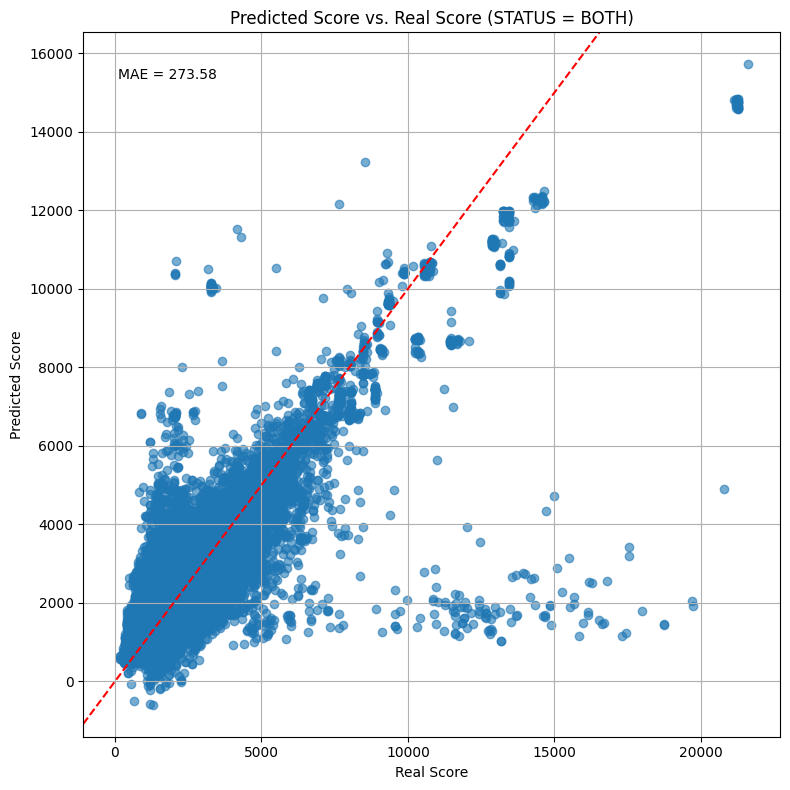

In [5]:
analyze_results_code.real_vs_predicted_score(df_filtered, mae)

## Hour boxplot of real scores

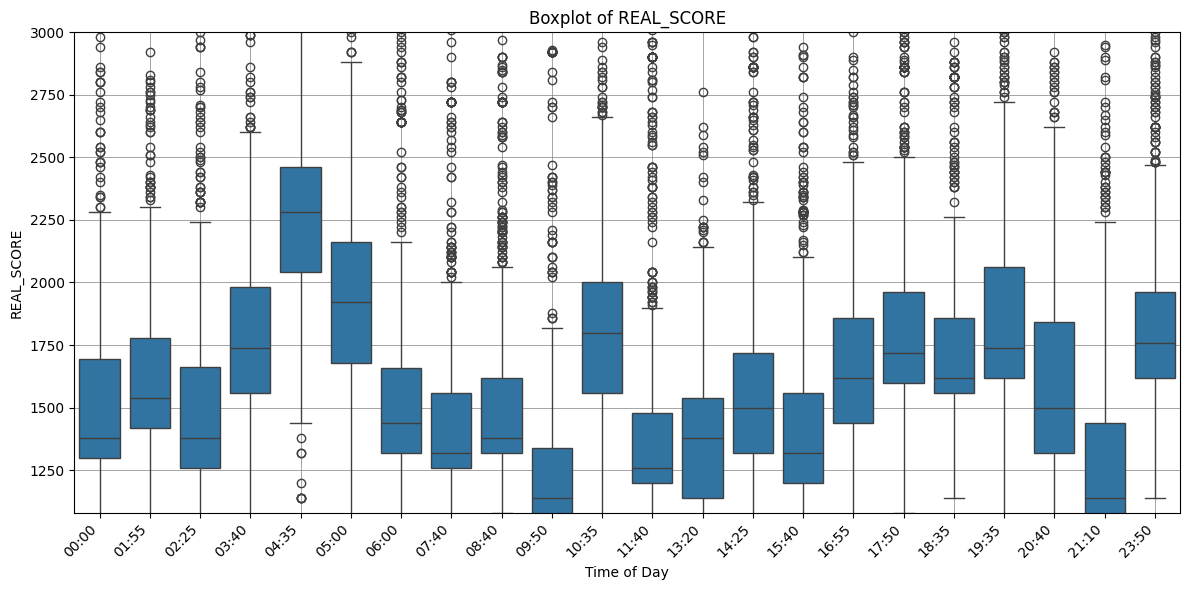

In [6]:
analyze_results_code.hour_boxplot(df_contg, "REAL_SCORE")

## Hour boxplot of predicted scores

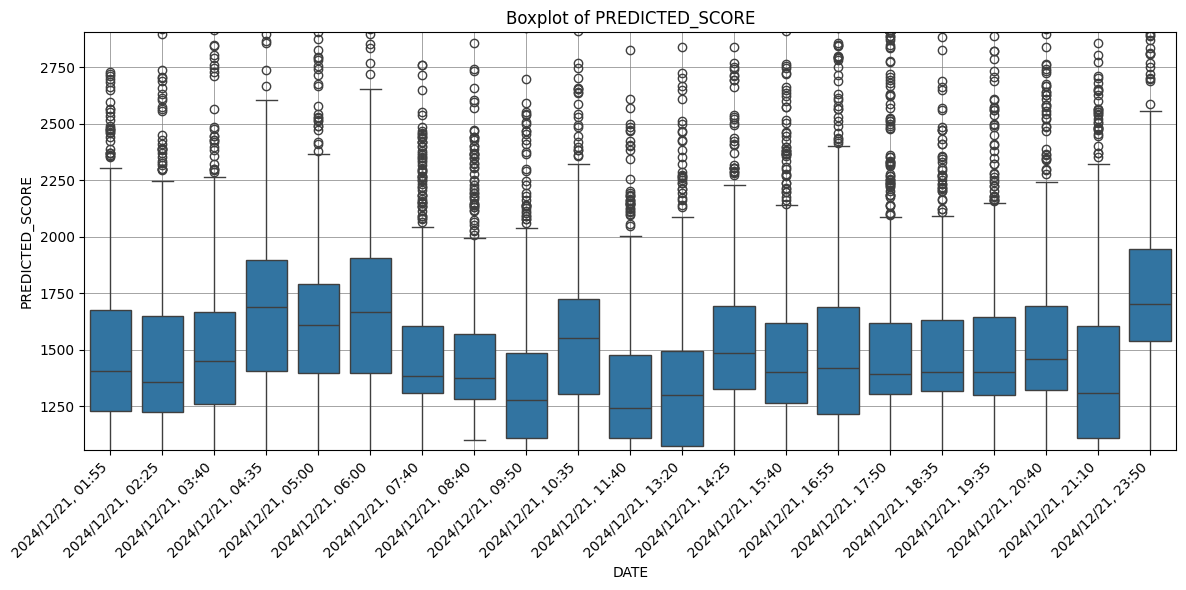

In [7]:
str_date_1 = "2024-12-21 00:00:00"
str_date_2 = "2024-12-21 23:59:59"
df_contg = df_contg.sort_values(by="DATE", ascending=True)

mask = (df_contg["DATE"] > datetime.strptime(str_date_1, "%Y-%m-%d %H:%M:%S")) & (
    df_contg["DATE"] <= datetime.strptime(str_date_2, "%Y-%m-%d %H:%M:%S")
)

df_filtered = df_contg.loc[mask]

df_filtered = df_filtered[df_filtered["STATUS"] == "BOTH"]

if not df_filtered.empty:
    plt.figure(figsize=(12, 6))  # Set the size of the figure
    ax = plt.axes()
    ax.set_facecolor("white")
    sns.boxplot(
        x=df_filtered["DATE"].dt.strftime("%Y/%m/%d, %H:%M"),
        y=pd.to_numeric(df_filtered["PREDICTED_SCORE"]),
    ).set(xlabel="DATE", ylabel="PREDICTED_SCORE")
    plt.xticks(rotation=45, ha="right")  # Rotate the x-axis labels and align them to the right

    # Calculate the dynamic limits for the y-axis (5th and 95th percentiles)
    lower_limit = df_filtered["PREDICTED_SCORE"].quantile(0.05)
    upper_limit = df_filtered["PREDICTED_SCORE"].quantile(0.95)
    if not pd.isna(lower_limit) and not pd.isna(upper_limit):
        plt.ylim(lower_limit, upper_limit)

    plt.grid(color="grey", linewidth=0.5)
    plt.title(f"Boxplot of PREDICTED_SCORE")  # Add a title to the plot
    plt.tight_layout()  # Adjust the layout so that elements do not overlap
    plt.show()
else:
    print("The DataFrame is empty, the plot cannot be generated.")

## Day boxplot of real scores

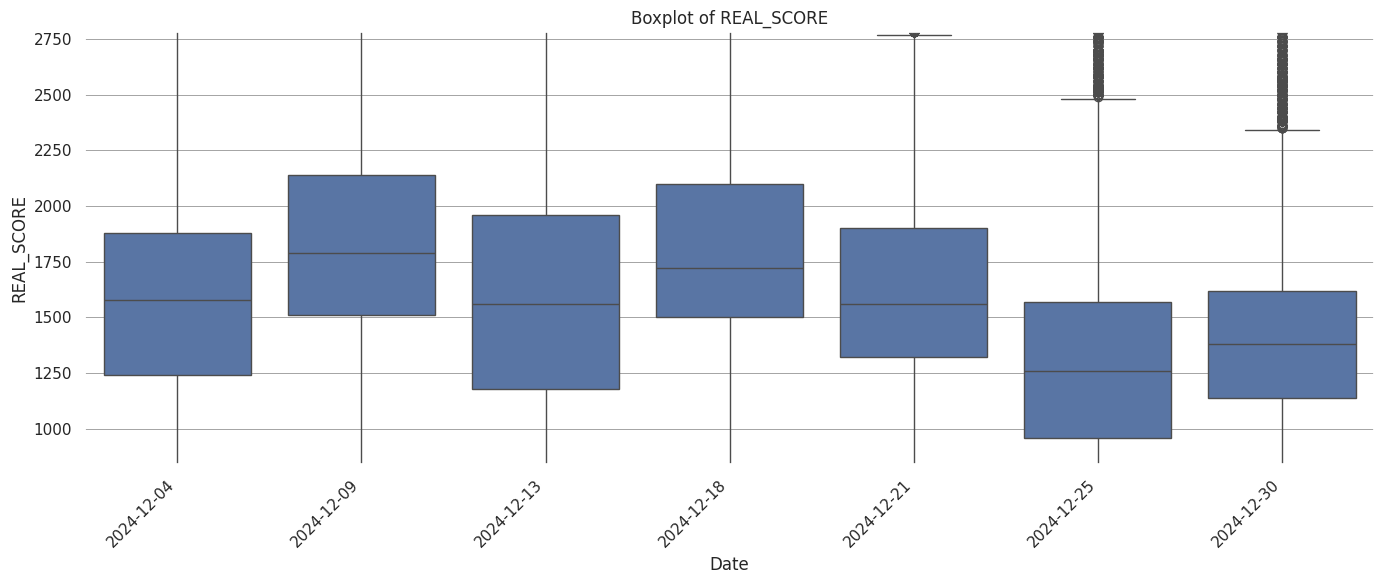

In [8]:
analyze_results_code.day_boxplot(df_contg, "REAL_SCORE")

## Day boxplot of predicted scores

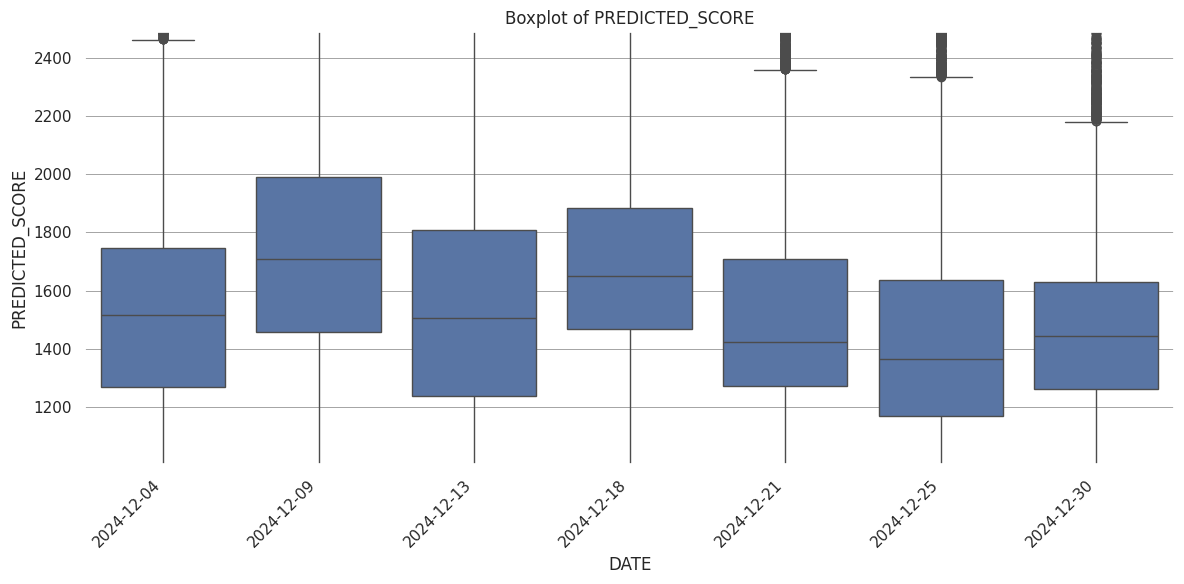

In [9]:
str_date_1 = "2024-12-01 00:00:00"
str_date_2 = "2024-12-31 23:59:59"
df_contg = df_contg.sort_values(by="DATE", ascending=True)

mask = (df_contg["DATE"] > datetime.strptime(str_date_1, "%Y-%m-%d %H:%M:%S")) & (
    df_contg["DATE"] <= datetime.strptime(str_date_2, "%Y-%m-%d %H:%M:%S")
)

df_filtered = df_contg.loc[mask]

df_filtered = df_filtered[df_filtered["STATUS"] == "BOTH"]

df_filtered["DATE"] = pd.to_datetime(df_filtered["DATE"], format="%Y-%m-%d %H:%M:%S").dt.date

if not df_filtered.empty:
    plt.figure(figsize=(12, 6))  # Set the size of the figure
    ax = plt.axes()
    ax.set_facecolor("white")
    sns.boxplot(x=df_filtered["DATE"], y=pd.to_numeric(df_filtered["PREDICTED_SCORE"])).set(
        xlabel="DATE", ylabel="PREDICTED_SCORE"
    )
    plt.xticks(rotation=45, ha="right")  # Rotate the x-axis labels and align them to the right

    # Calculate the dynamic limits for the y-axis (5th and 95th percentiles)
    lower_limit = df_filtered["PREDICTED_SCORE"].quantile(0.05)
    upper_limit = df_filtered["PREDICTED_SCORE"].quantile(0.95)
    if not pd.isna(lower_limit) and not pd.isna(upper_limit):
        plt.ylim(lower_limit, upper_limit)

    plt.grid(color="grey", linewidth=0.5)
    plt.title(f"Boxplot of PREDICTED_SCORE")  # Add a title to the plot
    plt.tight_layout()  # Adjust the layout so that elements do not overlap
    plt.show()
else:
    print("The DataFrame is empty, the plot cannot be generated.")

## Real score histogram

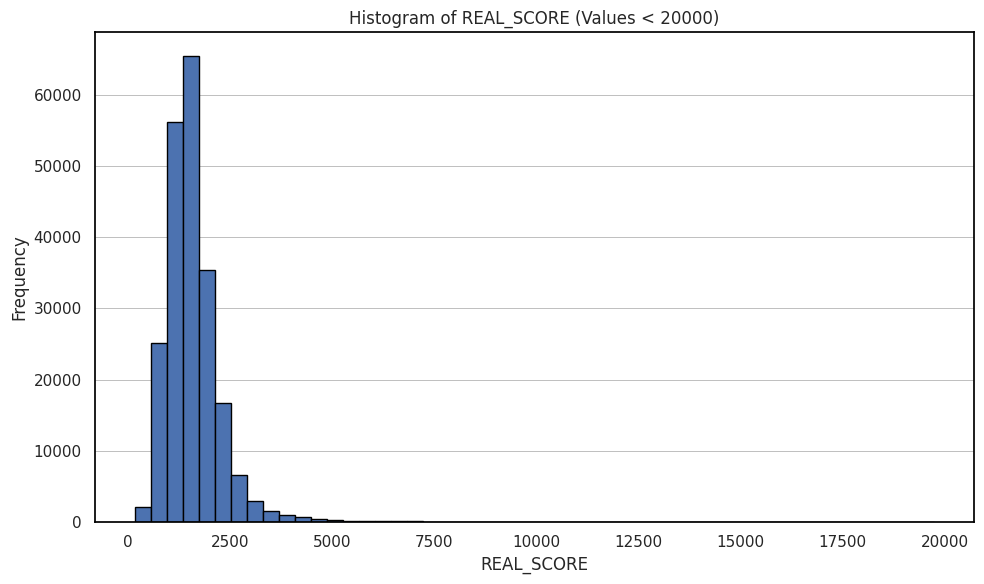

In [10]:
analyze_results_code.score_histogram(df_contg, "REAL_SCORE")

## Predicted score histogram

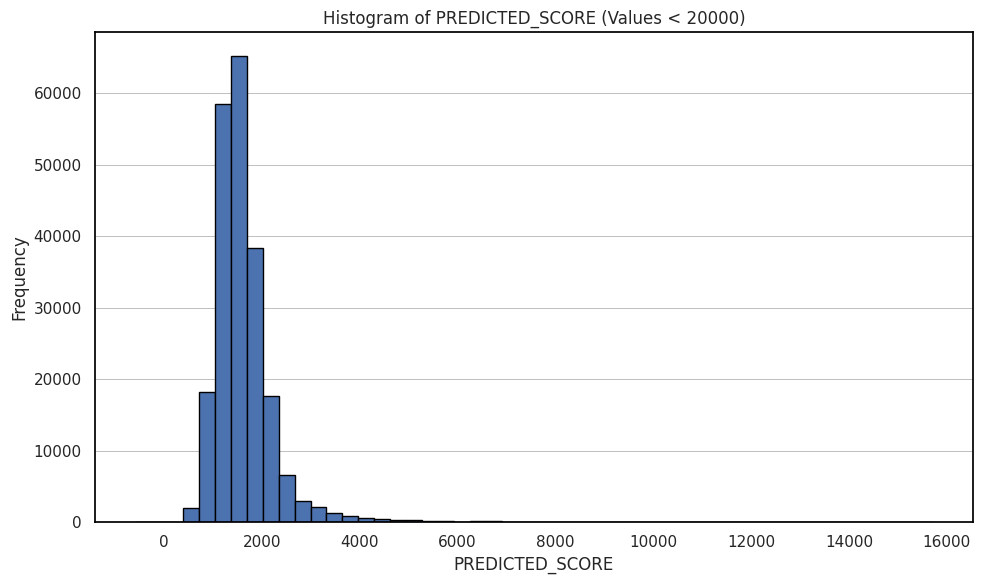

In [11]:
analyze_results_code.score_histogram(df_contg, "PREDICTED_SCORE")

## EBM explanation

In [12]:
df_contg_both = df_contg[df_contg["STATUS"] == "BOTH"].sort_values(by=["REAL_SCORE"], ascending=False)
data = df_contg_both.drop(columns=["PREDICTED_SCORE", "STATUS", "REAL_SCORE", "DATE"])

# 3. Generate the global explanation
global_explanation = ML_model.explain_global()

# 4. Visualize the global explanation
print("Showing global explanation...")
show(global_explanation)

# 5. Visualize local explanations (if you have data)
if data is not None:
    print("\nShowing local explanations for the local instances...")
    local_explanation = ML_model.explain_local(X=data, y=df_contg_both["REAL_SCORE"])
    show(local_explanation)

Showing global explanation...


<!-- http://127.0.0.1:7001/125077356688832/ -->


Showing local explanations for the local instances...


<!-- http://127.0.0.1:7001/125077366504480/ -->